This notebook needs to get cleaned up

In [2]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [62]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print('This notebook is not stale yet!')

This notebook is not stale yet!


In [16]:
# Test with the coastline flat
ntot_cf = 1 # goes from 1-8
D_full_cf = 50*u.mm
ca_80 = 80
oversamp_size = 4096
dr_width = 5
npix_diam_cf = []
var_cf = []

for ntest in range(0,ntot_cf):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/coastline_flat_correct.fits'
    surf_data = fits.getdata(surf_loc)*u.um

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_cf, ca_80, oversamp_size)

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_cf)

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test: {}'.format(np.sum(norm_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)

    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_cf = np.zeros((ntot_cf, np.shape(kval)[0]))
        mean_psd_cf = np.zeros((ntot_cf, np.shape(mean_val)[0]))

    kval_cf[ntest,:] = copy.copy(kval)
    mean_psd_cf[ntest,:] = copy.copy(mean_val)
    npix_diam_cf.append(npix_diam)
    var_cf.append(ap_var)

# force in the units, they will be the same across each iteration
kval_cf *= kval.unit
mean_psd_cf *= mean_val.unit
var_cf *= ap_var.unit

PSD normalized: var=1.000
var test: 0.9999999999999998
Finished calculating PSD for surface 0


Text(0, 0.5, 'Surface PSD [mm2] (variance normalized)')

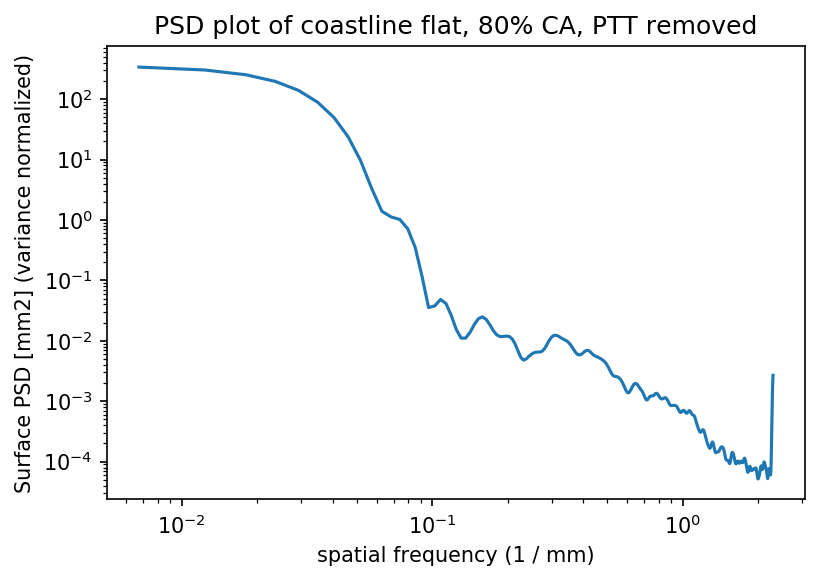

In [24]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
n_surf = 0
plt.figure(dpi=150)
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
for ns in range(0,ntot_cf):
    #plt.loglog(kval_cf[n_surf,:], mean_psd_cf[n_surf,:])
    plt.loglog(kval_cf[ns].value, mean_psd_cf[ns].value)
plt.title('PSD plot of coastline flat, 80% CA, PTT removed')
plt.xlabel('spatial frequency ({})'.format(kval_cf.unit))
plt.ylabel('Surface PSD [{}] (variance normalized)'.format(mean_psd_cf.unit)) 

In [15]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
    print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
    print('var at n{}: {:.3f}'.format(ntest+1, ap_var))

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)
    print('delta k at n{}: {:.5f}'.format(ntest+1, delta_k))

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test n{}: {:.3f}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
    print('cal var test n{}: {:.3f}'.format(ntest+1, np.sum(cal_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    #(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width)
    print('norm PSD units n{}: {}'.format(ntest+1, mv_n.unit)) # should be mm2
    print('cal PSD units n{}: {}'.format(ntest+1, mv_c.unit))  # should be mm2 nm2

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mn_psd_1 = np.zeros((ntot_1, np.shape(mv_n)[0]))
        mc_psd_1 = np.zeros((ntot_1, np.shape(mv_c)[0]))

    kval_1[ntest,:] = copy.copy(kval)
    mn_psd_1[ntest,:] = copy.copy(mv_n)
    mc_psd_1[ntest,:] = copy.copy(mv_c)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)
    surf_pwr_1[ntest,:,:] = copy.copy(pwr_opt)

# force in the units, they will be the same across each iteration
kval_1 *= kval.unit
mn_psd_1 *= mv_n.unit
mc_psd_1 *= mv_c.unit
var_1 *= ap_var.unit
surf_pwr_1 *= pwr_opt.unit

# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_1 = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_1[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
avg_psd_1 *= mn_psd_1.unit
    
# Step 4: scale the average PSD by the average of collection of individual variances in step 1
avg_cal_psd = avg_psd_1 * avg_tot_var

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1)

Crunching individual PSDs for 1 inch flats (8 total mirrors)
surf unit at n1: mm
var at n1: 9.169 nm2
delta k at n1: 0.00264 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 9.169 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
surf unit at n2: mm
var at n2: 8.807 nm2
delta k at n2: 0.00264 1 / mm
PSD normalized: var=1.000
var test n2: 1.000
cal var test n2: 8.807 nm2
norm PSD units n2: mm2
cal PSD units n2: mm2 nm2
Finished calculating PSD for surface 2
surf unit at n3: mm
var at n3: 11.048 nm2
delta k at n3: 0.00264 1 / mm
PSD normalized: var=1.000
var test n3: 1.000
cal var test n3: 11.048 nm2
norm PSD units n3: mm2
cal PSD units n3: mm2 nm2
Finished calculating PSD for surface 3
surf unit at n4: mm
var at n4: 6.522 nm2
delta k at n4: 0.00264 1 / mm
PSD normalized: var=1.000
var test n4: 1.000
cal var test n4: 6.522 nm2
norm PSD units n4: mm2
cal PSD units n4: mm2 nm2
Finished calculating PSD for surface 4
surf unit at 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

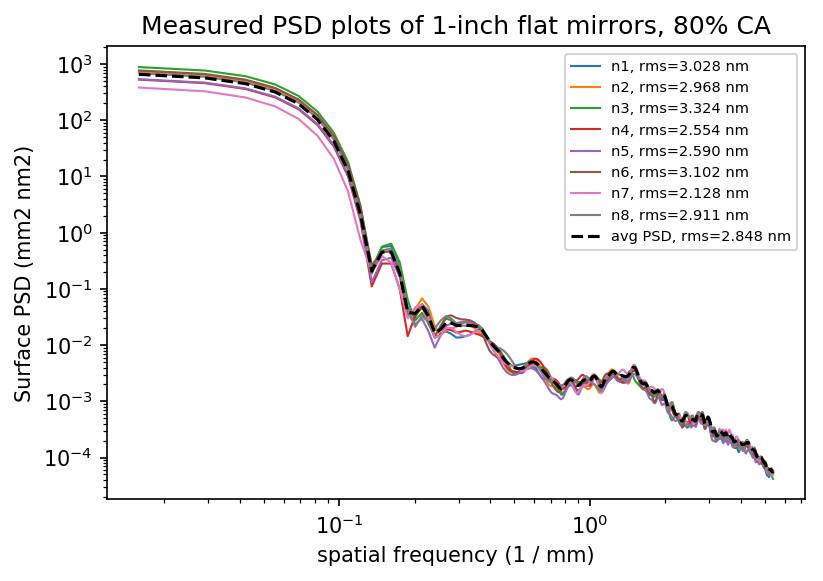

In [58]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of 1-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

Text(0, 0.5, 'Surface PSD (mm2) [var norm =1.0]')

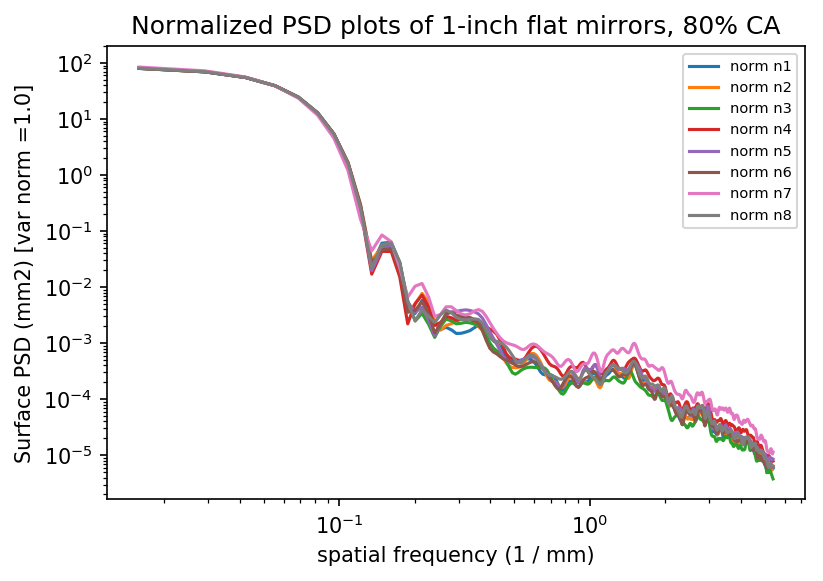

In [26]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mn_psd_1[ns,:], label='norm n{}'.format(ns+1))
plt.title('Normalized PSD plots of 1-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1.unit)) 

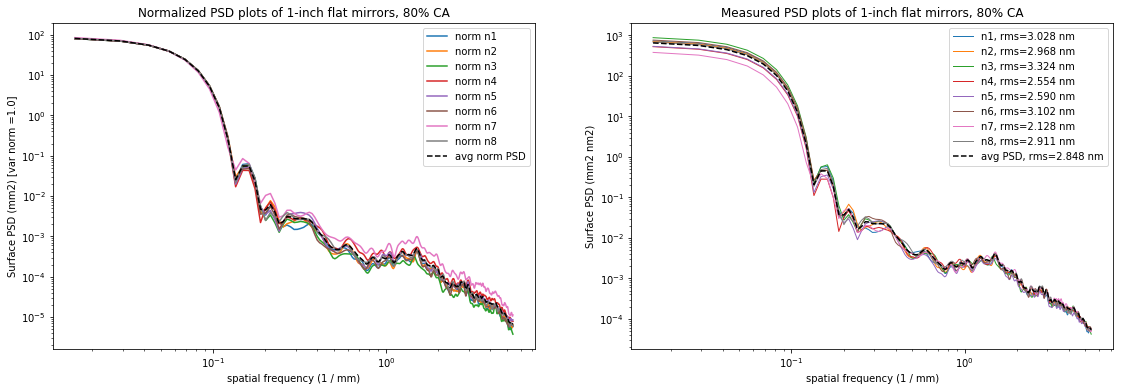

In [66]:
plt.figure(figsize=[19,6])

plt.subplot(1,2,1)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mn_psd_1[ns,:], label='norm n{}'.format(ns+1))
plt.loglog(kval_1[0,:], avg_psd_1, 'k--', label='avg norm PSD')
plt.title('Normalized PSD plots of 1-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.legend()
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1.unit)) 

plt.subplot(1,2,2)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1.0)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of 1-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.legend()
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

plt.show()

## OLD CODE VERSION

In [9]:
# 1 inch flats (8 total)

ca_val = 80
dr_width = 5

ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm
npix_diam_1 = []
var_1 = []

print('Crunching PSDs for 1 inch flats (8 total mirrors)')

for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_1, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mean_psd_1 = np.zeros((ntot_1, np.shape(mean_val)[0]))
    
    kval_1[ntest,:] = copy.copy(kval)
    mean_psd_1[ntest,:] = copy.copy(mean_val)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)

Crunching PSDs for 1 inch flats (8 total mirrors)
Finished calculating PSD for surface 0
Finished calculating PSD for surface 1
Finished calculating PSD for surface 2
Finished calculating PSD for surface 3
Finished calculating PSD for surface 4
Finished calculating PSD for surface 5
Finished calculating PSD for surface 6
Finished calculating PSD for surface 7


In [4]:
# 19mm flats (2 total)

ca_val = 80
dr_width = 5

ntot_19 = 2 # goes from 1-2
D_full_19 = 19*u.mm
npix_diam_19 = []
var_19 = []

print('Crunching PSDs for 19mm flats ({} total mirrors)'.format(ntot_19))

for ntest in range(0,ntot_19):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/19mm_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_19, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_19 = np.zeros((ntot_19, np.shape(kval)[0]))
        mean_psd_19 = np.zeros((ntot_19, np.shape(mean_val)[0]))
    
    kval_19[ntest,:] = copy.copy(kval)
    mean_psd_19[ntest,:] = copy.copy(mean_val)
    npix_diam_19.append(npix_diam)
    var_19.append(ap_var)

Crunching PSDs for 19mm flats (2 total mirrors)
Finished calculating PSD for surface 0
Finished calculating PSD for surface 1


In [5]:
# 0.5 inch flats (1 total)

ca_val = 80
dr_width = 5

ntot_05 = 1 # goes from 1
D_full_05 = 12.7*u.mm
npix_diam_05 = []
var_05 = []

print('Crunching PSDs for 0.5 inch flats ({} total mirrors)'.format(ntot_05))

for ntest in range(0,ntot_05):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/0p5in_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_05, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_05 = np.zeros((ntot_05, np.shape(kval)[0]))
        mean_psd_05 = np.zeros((ntot_05, np.shape(mean_val)[0]))
    
    kval_05[ntest,:] = copy.copy(kval)
    mean_psd_05[ntest,:] = copy.copy(mean_val)
    npix_diam_05.append(npix_diam)
    var_05.append(ap_var)

Crunching PSDs for 0.5 inch flats (1 total mirrors)
Finished calculating PSD for surface 0


## Build the PSD plots

In [17]:
npix_diam_1, npix_diam_05, npix_diam_19

([220, 220, 220, 220, 220, 220, 220, 220], [192], [168, 168])

In [19]:
np.shape(kval_1), np.shape(kval_05), np.shape(kval_19)

((8, 408), (1, 408), (2, 408))

In [28]:
for no in range(0,ntot_1):
    print('deltak at n{}: {}'.format(no,kval_1[0][1] - kval_1[0][0]))

deltak at n0: 0.013216273991141728
deltak at n1: 0.013216273991141728
deltak at n2: 0.013216273991141728
deltak at n3: 0.013216273991141728
deltak at n4: 0.013216273991141728
deltak at n5: 0.013216273991141728
deltak at n6: 0.013216273991141728
deltak at n7: 0.013216273991141728


In [25]:
alpha = 2
alpha_fit = 1/(kval_1[0][:]**alpha)

In [31]:
beta = np.zeros((ntot_1))
for ns in range(0,ntot_1):
    kmin = 1/(D_full_1.value*ca_val/100)
    kmax = 1/(2*D_full_1.value*(ca_val/100)/npix_diam_1[ns])
    beta[ns] = var_1[ns] / (2*np.pi * np.log(kmax/kmin) )
beta

array([3.16023293e-13, 3.03783599e-13, 3.81038900e-13, 2.25331885e-13,
       2.31614823e-13, 3.32070514e-13, 1.56813358e-13, 2.92517134e-13])

In [3]:
beta_avg1 = np.mean(beta)

kmin = 1/(D_full_1.value*ca_val/100)
kmax = 1/(2*D_full_1.value*(ca_val/100)/np.mean(npix_diam_1[ns]))
beta_avg2 = np.mean(var_1) / (2*np.pi * np.log(kmax/kmin) )

beta_avg1, beta_avg2

NameError: name 'beta' is not defined

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

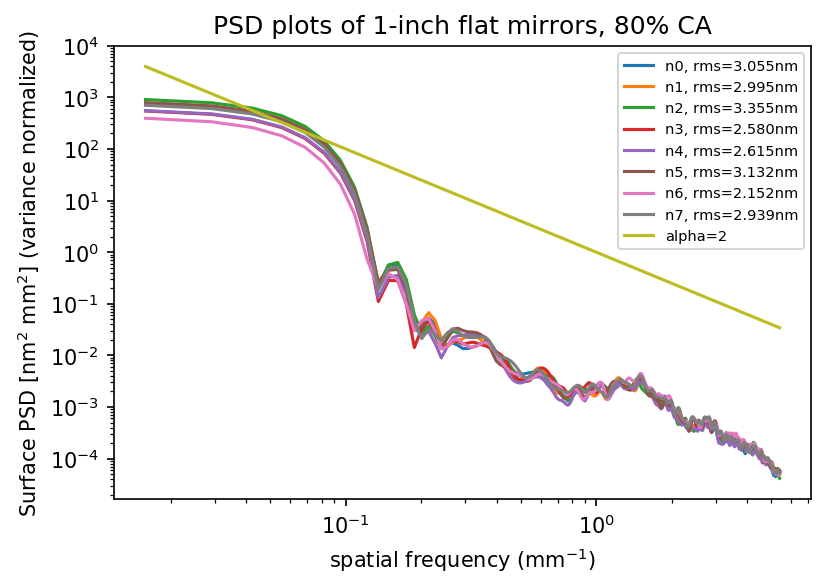

In [27]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
plt.loglog(kval_1[0][:], alpha_fit, label='alpha={}'.format(alpha))
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

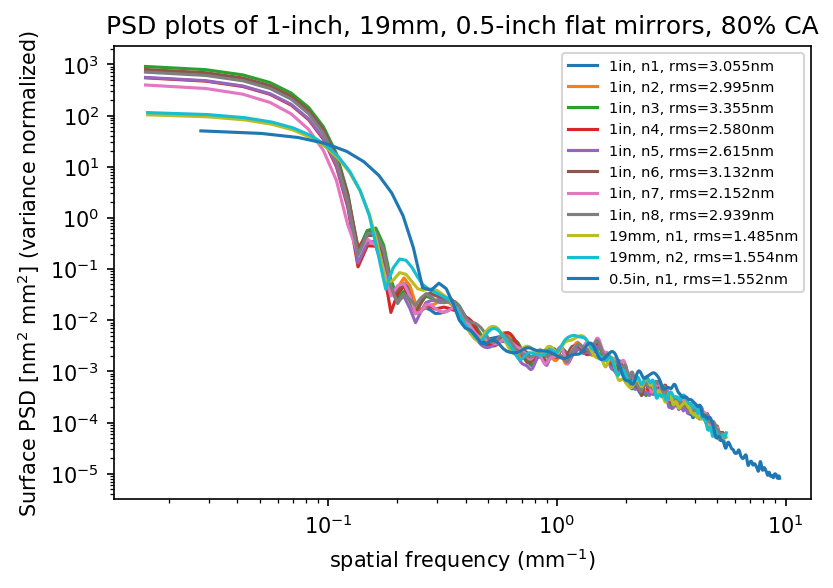

In [14]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='1in, n{}, rms={:.3f}nm'.format(ns+1, rms_1[ns]))
for ns in range(0,ntot_19):
    plt.loglog(kval_19[ns,:], [i*1e12 for i in mean_psd_19[ns,:]], label='19mm, n{}, rms={:.3f}nm'.format(ns+1, rms_19[ns]))
for ns in range(0,ntot_05):
    plt.loglog(kval_05[ns,:], [i*1e12 for i in mean_psd_05[ns,:]], label='0.5in, n{}, rms={:.3f}nm'.format(ns+1, rms_05[ns]))
plt.title('PSD plots of 1-inch, 19mm, 0.5-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

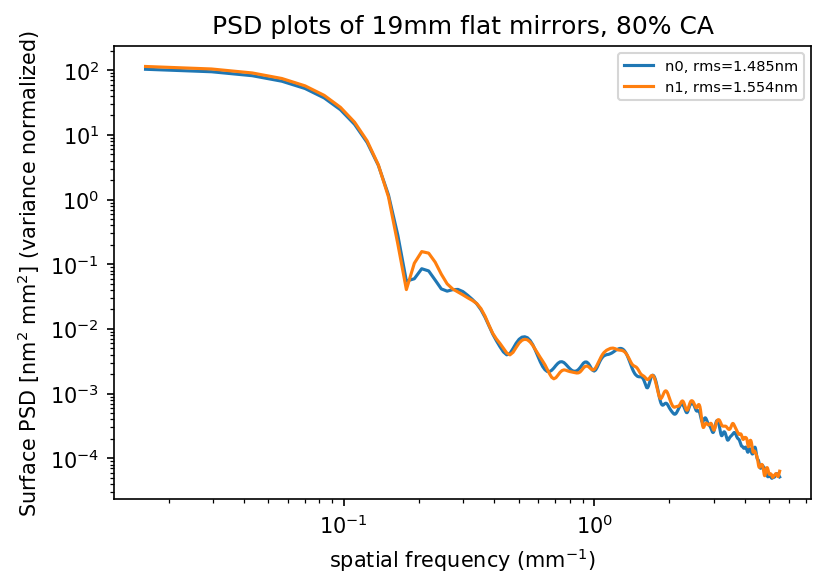

In [7]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_19 = np.sqrt(var_19)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_19):
    plt.loglog(kval_19[ns,:], [i*1e12 for i in mean_psd_19[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_19[ns]))
plt.title('PSD plots of 19mm flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

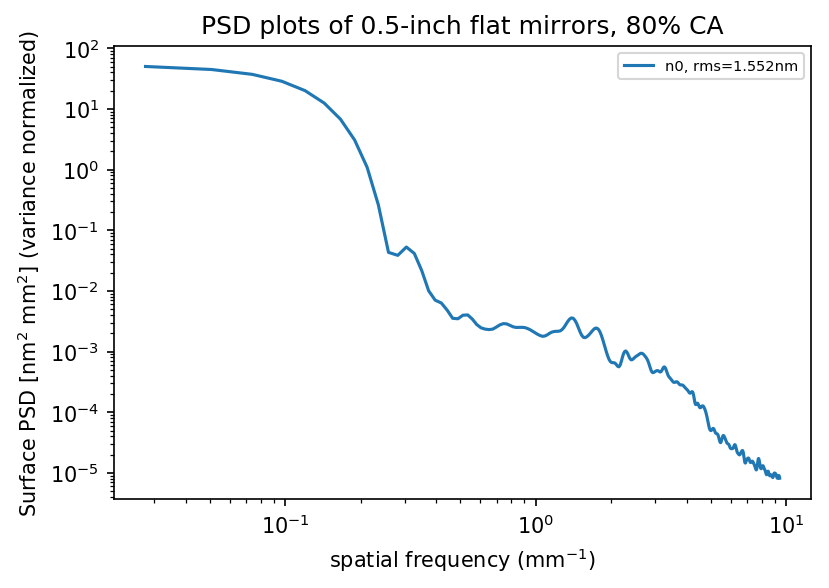

In [8]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_05 = np.sqrt(var_05)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_05):
    plt.loglog(kval_05[ns,:], [i*1e12 for i in mean_psd_05[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_05[ns]))
plt.title('PSD plots of 0.5-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

## Investigating shapes of arrays
All content here is notes and nothing useful, maybe.

In [26]:
ntot_1in = 8 # goes from 1-8
data_shape_arr = []
new_optic_arr = []
for ntest in range(0,ntot_1in):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    
    # if the optics are not the same shape, cut down the edges of where there would be extra zeros.
    if np.shape(optic)[0] < np.shape(optic)[1]:
        diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
        new_optic = optic[:,np.int(diff/2):np.shape(optic)[1]-np.int(diff/2)]
    elif np.shape(optic)[0] > np.shape(optic)[1]:
        diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
        new_optic = optic[np.int(diff/2):np.shape(optic)[0]-np.int(diff/2),:]
    else:
        new_optic=optic
    
    new_optic_arr.append(np.shape(new_optic))


In [27]:
data_shape_arr

[(276, 276),
 (276, 280),
 (276, 280),
 (276, 276),
 (276, 280),
 (276, 280),
 (280, 276),
 (280, 276)]

In [28]:
new_optic_arr

[(276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276)]

In [24]:
surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n2_mediansurface.fits'.format(ntest+1)
optic, optic_header = fits.getdata(surf_loc, header=True)
np.shape(optic)

(276, 280)

In [25]:
if np.shape(optic)[0] < np.shape(optic)[1]:
    diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
    new_optic = optic[:,np.int(diff/2):np.shape(optic)[1]-np.int(diff/2)]
elif np.shape(optic)[0] > np.shape(optic)[1]:
    diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
    new_optic = optic[np.int(diff/2):np.shape(optic)[0]-np.int(diff/2),:]
else:
    new_optic=optic
np.shape(new_optic)

(276, 276)

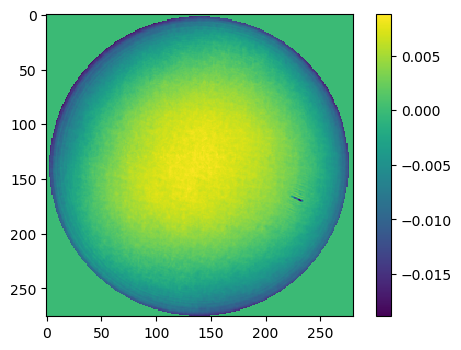

In [18]:
plt.figure(dpi=100)
plt.imshow(optic)
plt.colorbar()

In [19]:
optic_data = psd.zeroPadSquare(optic)
np.shape(optic_data)

(280, 280)

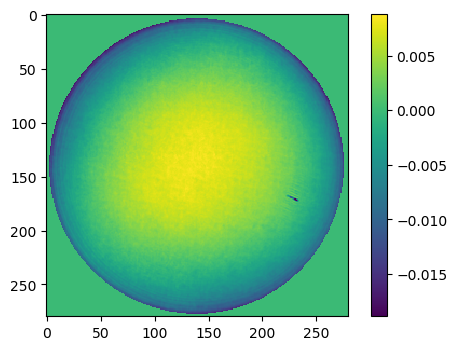

In [20]:
plt.figure(dpi=100)minimum
plt.imshow(optic_data)
plt.colorbar()

In [5]:
ntot_2in = 8 # goes from 1-8
data_shape_arr_2in = []
for ntest in range(0,ntot_2in):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    data_shape_arr_2in.append(np.shape(optic))
data_shape_arr_2in

[(564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564)]

In [6]:
ntot_19mm = 2 # goes from 1-8
data_shape_arr_19mm = []
for ntest in range(0,ntot_19mm):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/19mm_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    data_shape_arr_19mm.append(np.shape(optic))
data_shape_arr_19mm

[(212, 212), (212, 212)]

In [7]:
surf_loc = 'zygo_data/flat_mirrors/median_combined/0p5in_n1_mediansurface.fits'
optic, optic_header = fits.getdata(surf_loc, header=True)
np.shape(optic)

(240, 244)